In [7]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [11]:
import pandas as pd

df = pd.read_csv("spam.csv",encoding='latin-1')
df.head(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [13]:
df = df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'])
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [14]:
df.rename(columns={'v1':'Category','v2':'Message'},inplace=True)

In [15]:
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [16]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    653  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [17]:
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [18]:
747/4825


0.15481865284974095

In [19]:
# 15% Spam Data and 85% Not Spam data
# This shows data imbalance

In [26]:
df_spam=df[df['Category']=='spam']
df_ham=df[df['Category']=='ham']
print(df_spam.shape)
print(df_ham.shape)

(747, 2)


(4825, 2)

In [28]:
df_ham_balanced=df_ham.sample(df_spam.shape[0])
print(df_ham_balanced.shape)
df_balanced=pd.concat([df_ham_balanced,df_spam])
print(df_balanced.shape)

(747, 2)
(1494, 2)


In [29]:
df_balanced['Category'].value_counts()

ham     747
spam    747
Name: Category, dtype: int64

In [31]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x:1 if x =='spam' else 0)
df_balanced.head(10)

,Category,Message,spam
3317,ham,I'm freezing and craving ice. Fml,0
363,ham,Busy here. Trying to finish for new year. I am...,0
3880,ham,Can you plz tell me the ans. BSLVYL sent via f...,0
4107,ham,Pls send me your address sir.,0
5554,ham,Well keep in mind I've only got enough gas for...,0
1860,ham,"It could work, we'll reach a consensus at the ...",0
3663,ham,Huh? 6 also cannot? Then only how many mistakes?,0
1761,ham,Got ur mail Dileep.thank you so muchand look f...,0
5083,ham,Aiya we discuss later lar... Pick Ì_ up at 4 i...,0
581,ham,Ok anyway no need to change with what you said,0


In [32]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(df_balanced['Message'],df_balanced['spam'],stratify=df_balanced['spam'])

In [33]:
X_train.head()

1628            Yes princess! I want to make you happy...
2437    For ur chance to win å£250 cash every wk TXT: ...
872                       I'll text you when I drop x off
289     Dear,shall mail tonite.busy in the street,shal...
3165    HOT LIVE FANTASIES call now 08707509020 Just 2...
Name: Message, dtype: object

In [34]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [35]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up", 
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.843517  , -0.51327264, -0.8884572 , ..., -0.74748856,
        -0.75314724,  0.91964495],
       [-0.8720835 , -0.50543964, -0.94446677, ..., -0.85847515,
        -0.71745354,  0.8808298 ]], dtype=float32)>

In [36]:
e = get_sentence_embeding([
    "cheetah", 
    "lion",
    "tiger",
    "mango",
    "apple",
    "banana"
]
)

In [39]:
# Here we use cosine similarity to see whether the embeddings point to the same vectore or not.
# i.e The words having similar meaning show have more similarity
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[1]],[e[2]])

array([[0.99345696]], dtype=float32)

For lion and Tiger we got 99% similarity but for lion and apple

In [44]:
cosine_similarity([e[0]],[e[3]])

array([[0.8726284]], dtype=float32)

In [45]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [46]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [47]:
len(X_train)

1120

In [48]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [49]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 219s 6s/step - loss: 0.6544 - accuracy: 0.6098 - precision: 0.6037 - recall: 0.6393
Epoch 2/10
35/35 [==============================] - 207s 6s/step - loss: 0.5284 - accuracy: 0.7911 - precision: 0.8159 - recall: 0.7518
Epoch 3/10
35/35 [==============================] - 198s 6s/step - loss: 0.4465 - accuracy: 0.8571 - precision: 0.8333 - recall: 0.8929
Epoch 4/10
35/35 [==============================] - 178s 5s/step - loss: 0.3988 - accuracy: 0.8652 - precision: 0.8619 - recall: 0.8696
Epoch 5/10
35/35 [==============================] - 196s 6s/step - loss: 0.3679 - accuracy: 0.8839 - precision: 0.8656 - recall: 0.9089
Epoch 6/10
35/35 [==============================] - 185s 5s/step - loss: 0.3482 - accuracy: 0.8741 - precision: 0.8708 - recall: 0.8786
Epoch 7/10
35/35 [==============================] - 183s 5s/step - loss: 0.3271 - accuracy: 0.8920 - precision: 0.8844 - recall: 0.9018
Epoch 8/10
35/35 [==============================

In [50]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 63s 5s/step - loss: 0.2669 - accuracy: 0.9198 - precision: 0.9110 - recall: 0.9305


[0.2668518126010895,
 0.9197860956192017,
 0.9109947681427002,
 0.9304812550544739]

In [52]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

12/12 [==============================] - 61s 5s/step


In [53]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,

Text(33.0, 0.5, 'Truth')

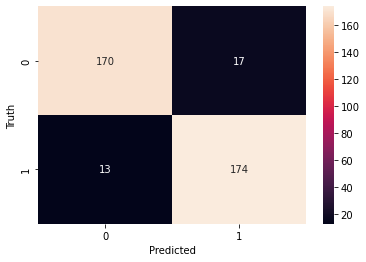

In [54]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [55]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92       187
           1       0.91      0.93      0.92       187

    accuracy                           0.92       374
   macro avg       0.92      0.92      0.92       374
weighted avg       0.92      0.92      0.92       374

